### Packages and modules load

In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from src import plots, clustering, density

El desafío consiste en:
Generar un pequeño EDA (exploratory data analysis | análisis exploratorio de variables)
Comparar al menos 2 metodologías de clustering sobre el dataset
Elegir el mejor método y cantidad de clusters según criterios que no solo sean métricas internas (ejemplo: distancia inter-clusters) sino también lógicas de composición de cada cluster (patrones que se encuentren en cada uno de ellos), como por ejemplo, qué variables son más importantes en cada segmento
Se tendrán en cuenta tanto las capacidades técnicas de clustering utilizadas como el storytelling final de los clusters.
Se solicita que por favor, adjunto a la resolución del desafío, el mismo venga acompañado de un video de no más de diez minutos en donde se pueda ver la pantalla y se escuche tu voz (en inglés preferentemente) poniendo de manifiesto la lógica y el razonamiento con el que el mismo se llevó adelante. 

### Dataset load

In [215]:
df = pd.read_csv("/home/asado/Descargas/rockingData/dataset/dataset_desafio (3).csv")
df.sample(5, random_state=42) #seed of randomness for reproducibility

,song_name,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_genres,artist_popularity,artist_followers,release_year
84,Maniac,Michael Sembello,Flashdance (Original Soundtrack From The Motio...,0.617,0.533,3,-11.516,0,0.0651,0.08910,0.000004,0.0415,0.835,158.860,244707,77,['hi-nrg'],61,69246,1983
259,Pinta,Bizarrap,Pinta,0.733,0.896,9,-3.250,1,0.1570,0.18700,0.000000,0.0671,0.941,88.059,177950,60,"['argentine hip hop', ' pop venezolano', ' tra...",86,7449300,2022
45,"Paint It, Black",The Rolling Stones,Aftermath,0.464,0.795,1,-9.267,1,0.0926,0.04930,0.002440,0.3990,0.612,158.691,202267,80,"['british invasion', ' classic rock', ' rock']",78,12233730,1966
176,Private Dancer - 2015 Remaster,Tina Turner,Private Dancer (30th Anniversary Issue),0.587,0.572,2,-9.656,1,0.0413,0.36300,0.087100,0.0915,0.471,115.466,434373,58,"['disco', ' new wave pop', ' soft rock']",69,3118475,1984
143,"You're My Heart, You're My Soul '98",Modern Talking,Back For Good,0.752,0.938,1,-4.080,0,0.0381,0.00455,0.004720,0.0855,0.967,119.322,230267,60,"['eurodance', ' europop', ' german pop', ' syn...",66,1105981,1998


### Descriptive analysis

In [60]:
print(f"This dataset is composed of {df.shape[0]} rows and {df.shape[1]} columns")

This dataset is composed of 291 rows and 20 columns


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   song_name          291 non-null    object 
 1   artist             291 non-null    object 
 2   album              291 non-null    object 
 3   danceability       291 non-null    float64
 4   energy             291 non-null    float64
 5   key                291 non-null    int64  
 6   loudness           291 non-null    float64
 7   mode               291 non-null    int64  
 8   speechiness        291 non-null    float64
 9   acousticness       291 non-null    float64
 10  instrumentalness   291 non-null    float64
 11  liveness           291 non-null    float64
 12  valence            291 non-null    float64
 13  tempo              291 non-null    float64
 14  duration_ms        291 non-null    int64  
 15  song_popularity    291 non-null    int64  
 16  artist_genres      291 non

There's a mix between integers, floats and string type of variables.

In [10]:
df.isna().sum()/df.shape[0]*100

song_name            0.0
artist               0.0
album                0.0
danceability         0.0
energy               0.0
key                  0.0
loudness             0.0
mode                 0.0
speechiness          0.0
acousticness         0.0
instrumentalness     0.0
liveness             0.0
valence              0.0
tempo                0.0
duration_ms          0.0
song_popularity      0.0
artist_genres        0.0
artist_popularity    0.0
artist_followers     0.0
release_year         0.0
dtype: float64

No NA's on the dataset

In [11]:
df.nunique()/df.shape[0]*100

song_name            100.000000
artist                74.570447
album                 87.628866
danceability          81.786942
energy                86.941581
key                    4.123711
loudness              98.969072
mode                   0.687285
speechiness           76.975945
acousticness          94.501718
instrumentalness      68.384880
liveness              81.099656
valence               82.817869
tempo                 99.656357
duration_ms           99.656357
song_popularity       26.460481
artist_genres         58.075601
artist_popularity     23.367698
artist_followers      74.914089
release_year          19.243986
dtype: float64

Due to their high variability I wont use "song_name" and "album" name variables, so I'll drop them.

In [216]:
df = df.drop(["song_name","album"], axis = 1)

### Numerical variables EDA

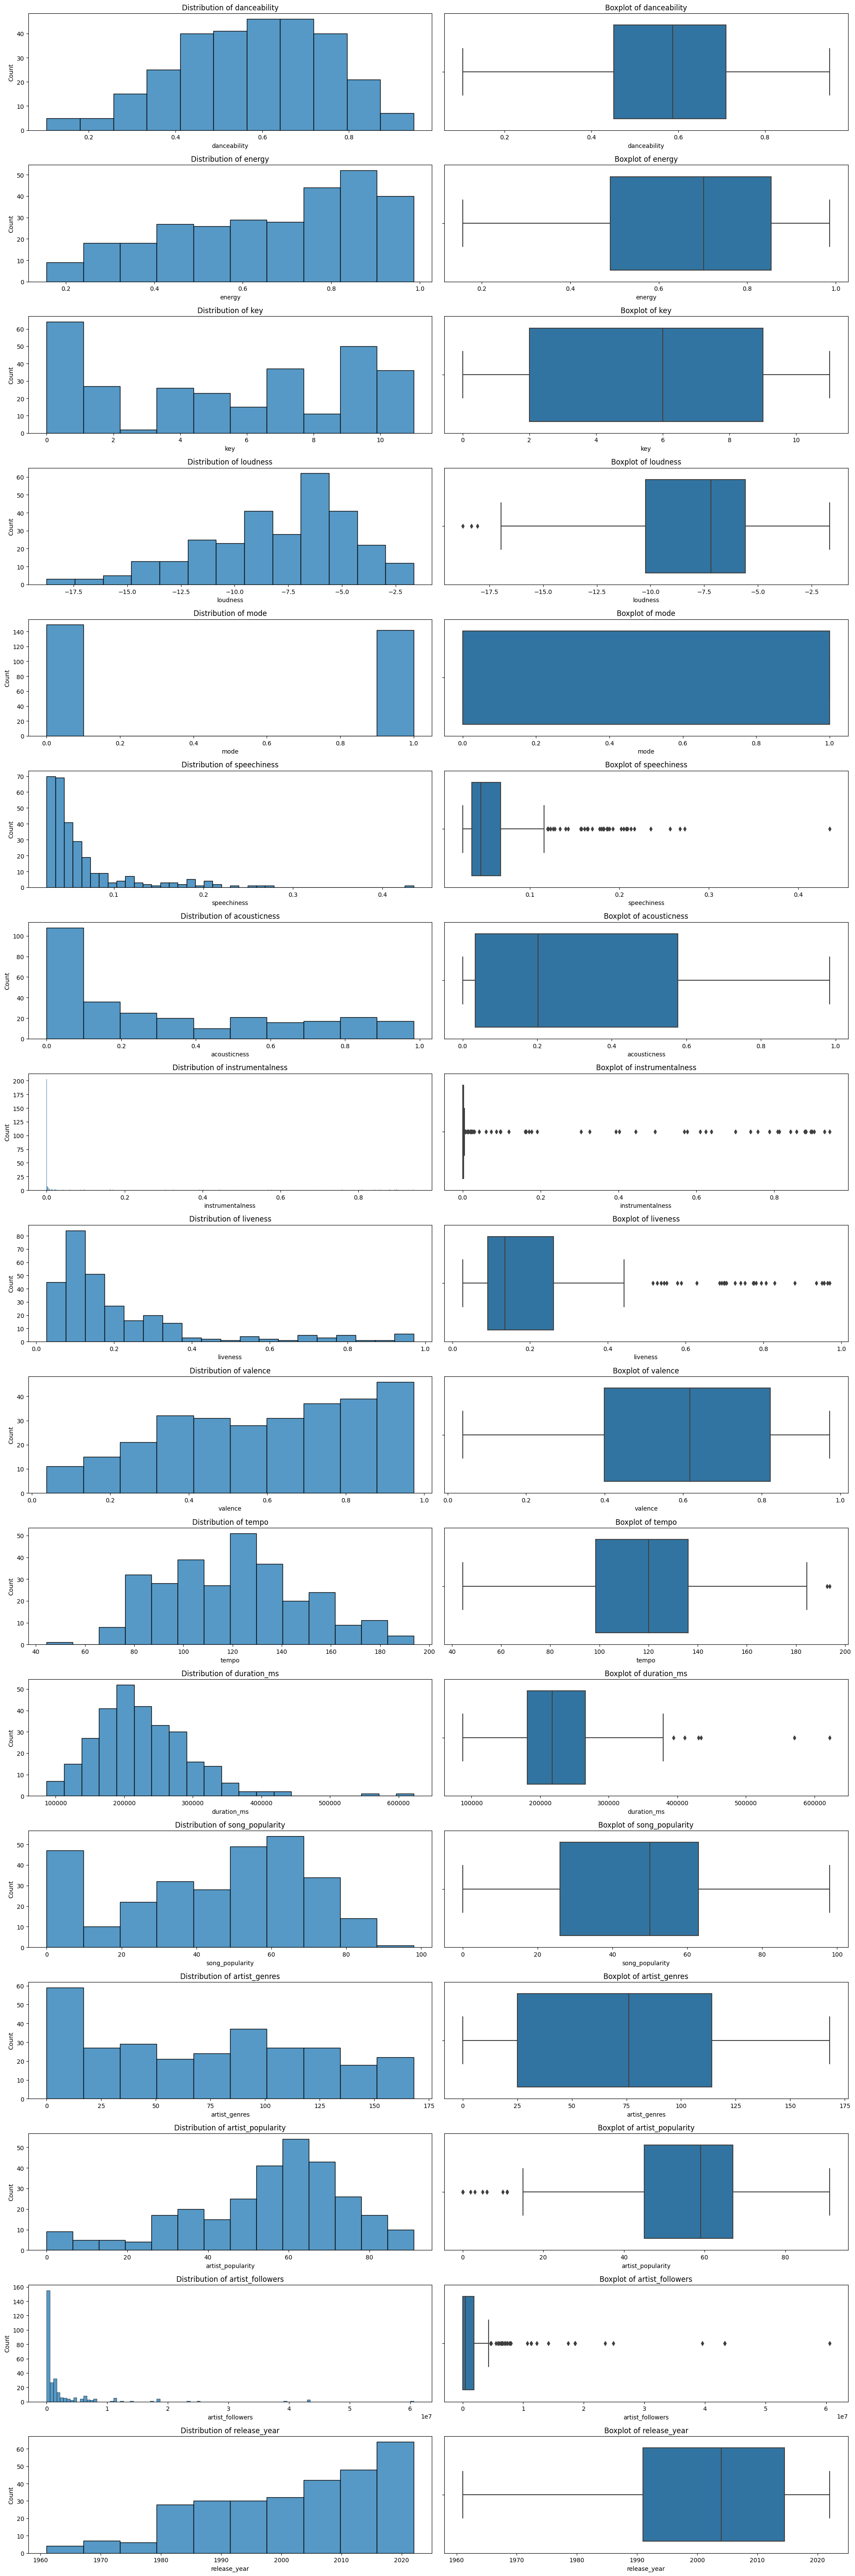

In [103]:
plots.plot_numeric_variables(df)

- There's a mix of variables with different scales. A few have ranges between 0 and 1 (liveness, speechiness, etc.) but most have bigger scales, indicating the need to deal deal with this issue properly. 
- Many variables are zero inflated (e.g instrumentalness and artist_followers) indicating that there is and overrepresentation of song with 0 instrumentalness and most of our dataset is dominated by not so popular artist.
- Bearing in mind that our scope is to cluster similarities and not outliers detction, some variables, like speechiness and instrumentalness, have obvious outliers observations that should be removed. 

### Categorical Variables EDA

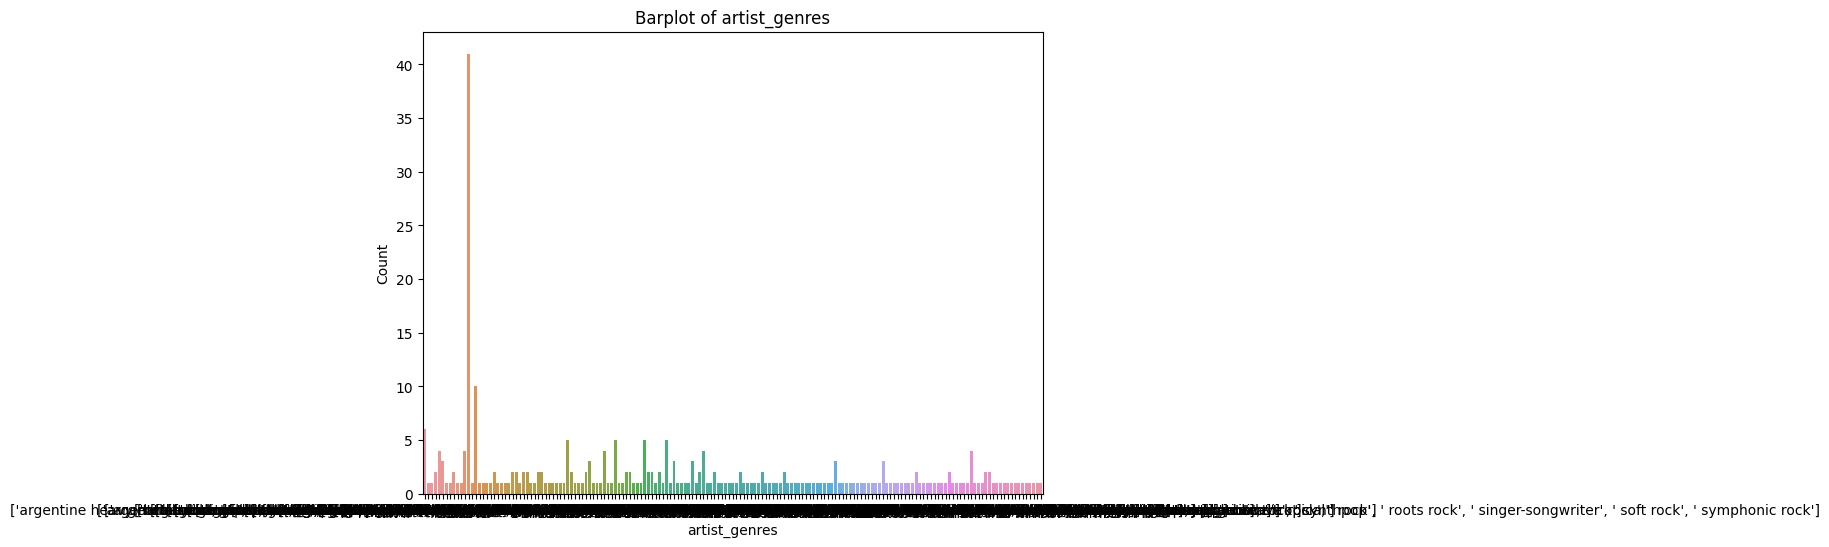

In [148]:
plots.plot_categorical_variables(df)

I'll try to disrciminate in a table the different values of our categorical values to check if there's some weird values among them.

In [302]:
df["artist"].value_counts()

Patricio Rey y sus Redonditos de Ricota    7
Bon Jovi                                   5
Madonna                                    5
Billy Joel                                 5
Édith Piaf                                 4
                                          ..
Tan Bionica                                1
Bananarama                                 1
Haddaway                                   1
Gliese                                     1
Los Lobos                                  1
Name: artist, Length: 217, dtype: int64

In [9]:
df["artist_genres"].value_counts()

['[]']                                                                                                                   41
['argentine rock', ' latin alternative', ' latin rock', ' post-punk argentina', ' rock en espanol', ' rock nacional']    10
['cumbia villera']                                                                                                        6
['glam metal', ' rock']                                                                                                   5
['disco', ' new wave pop', ' soft rock']                                                                                  5
                                                                                                                         ..
['["canzone dautore"', ' classic italian pop', ' italian adult pop']                                                      1
['swedish pop']                                                                                                           1
['musica

I could detect observations without a genre which where codified with a '[]', so i'll drop this observations.

In [217]:
df = df[df['artist_genres'] != "['[]']"]

Let's check it

In [6]:
df["artist_genres"].value_counts()

['argentine rock', ' latin alternative', ' latin rock', ' post-punk argentina', ' rock en espanol', ' rock nacional']    10
['cumbia villera']                                                                                                        6
['glam metal', ' rock']                                                                                                   5
['disco', ' new wave pop', ' soft rock']                                                                                  5
['dance pop', ' pop']                                                                                                     5
                                                                                                                         ..
['["canzone dautore"', ' classic italian pop', ' italian adult pop']                                                      1
['swedish pop']                                                                                                           1
['musica

Now that we have a dataset that is fairly ready to work with, I'll subset only the numerical variables for the clustering analysis and separate the categorical features for *a posteriori* analysis on the cluster internal compositional logic.

<AxesSubplot: >

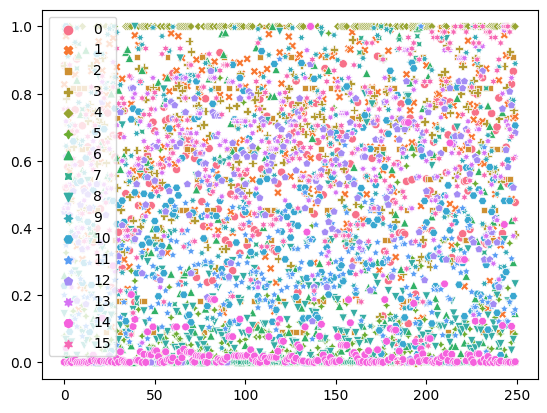

In [218]:
x = df.copy()
x = x.drop(["artist_genres", "artist"], axis = 1)
# Nomalized features of the original dataframe
scaled_x= MinMaxScaler().fit_transform(x) #MinMax was chosen due to convenience for this type of problem where many of the variables are not Normal and for better averall perfomance (in terms of Inertia and Silohouette score, see below)
sns.scatterplot(scaled_x)

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

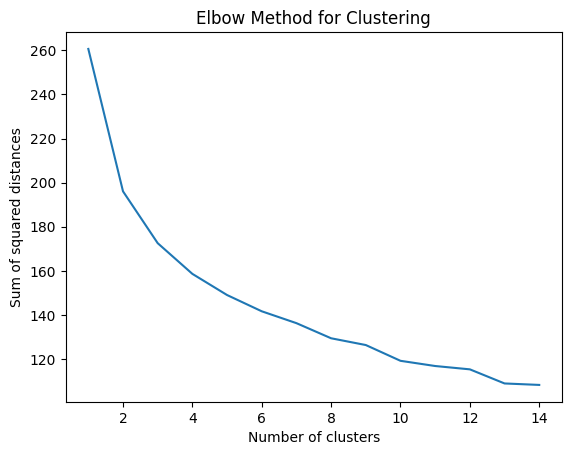

In [33]:
clustering.elbow_method(scaled_x)

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

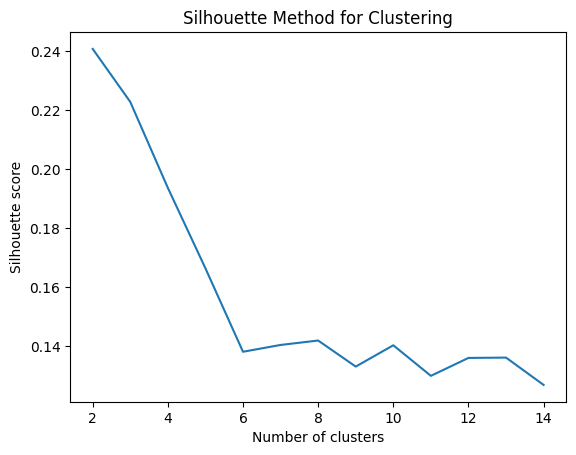

In [34]:
clustering.silhouette_method(scaled_x)

It seems that the best bias/variance balence is reached with 3 clusters. 

In [35]:
# Initialize the KMeans model with 8 clusters
kmeans = KMeans(n_clusters=3, random_state=1)

# Fit the model to the data
clusters = kmeans.fit_predict(scaled_x)  
# Calculate the silhouette score for the generated clusters
silhouette_score(scaled_x, clusters)

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.22744062262554207

#### Plot of the clusters 

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/src/clustering.py:84: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=df2, x='x', y='y', hue='labels', palette=palette)


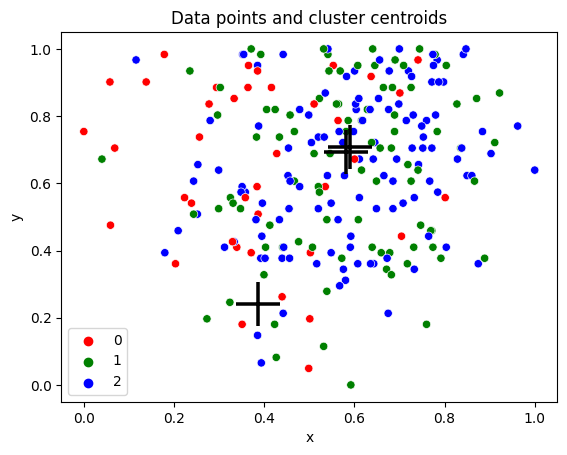

In [36]:
clustering.plot_clusters_with_centroids(scaled_x, kmeans)

#### Features importance on each cluster

In [37]:
# Normalize the values of each column
clustered_df = (x - x.mean()) / x.std()
# Create a new dataframe with the cluster assignments as a column
clustered_df['cluster'] = clusters

         danceability    energy       key  loudness      mode  speechiness  \
cluster                                                                      
0           -0.860896 -1.488910  0.209723 -1.197651  0.655794    -0.324355   
1            0.131111  0.243060 -0.242893  0.225820  1.014096     0.085797   
2            0.180365  0.299575  0.116034  0.217990 -0.982156     0.040353   

         acousticness  instrumentalness  liveness   valence     tempo  \
cluster                                                                 
0            1.513302          0.984109 -0.218575 -1.029704 -0.874568   
1           -0.372476         -0.209732  0.098592  0.169304  0.261210   
2           -0.209362         -0.160789 -0.003729  0.206265  0.086150   

         duration_ms  song_popularity  artist_popularity  artist_followers  \
cluster                                                                      
0          -0.303719        -0.371007          -0.376314         -0.273569   
1        

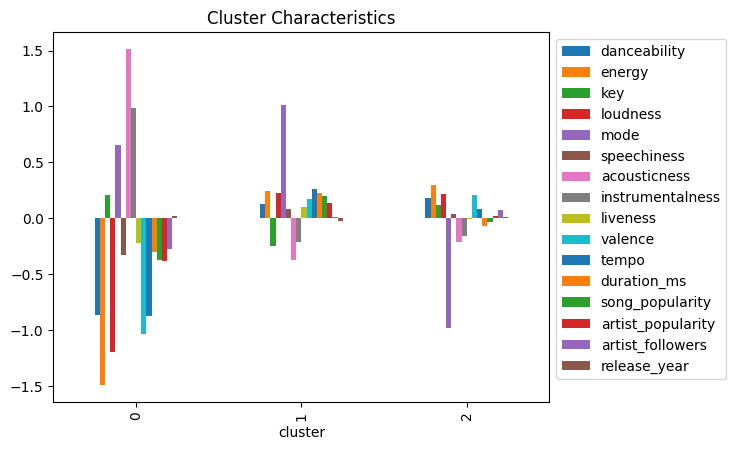

In [38]:
clustering.clustering_and_plot_characteristics(clustered_df)

### Dimensionality reduction with PCA

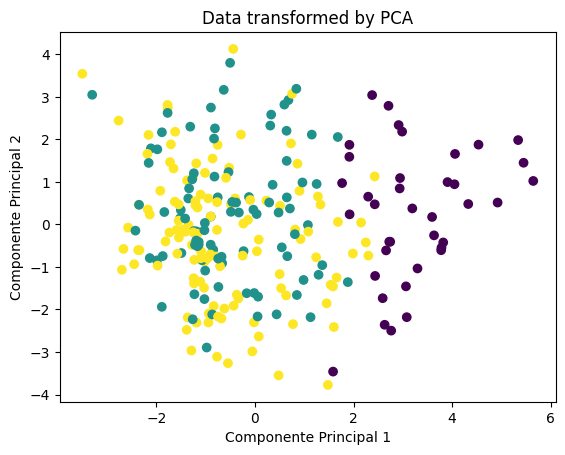

Variance proportions explained by each component
[0.20119473 0.14856846]
Eigenvalues and eigenvectors
[[-0.22762161 -0.4849401   0.02025498 -0.4206888   0.12068524 -0.08610144
   0.42461892  0.24895058 -0.12414356 -0.29608085 -0.26017566 -0.06439521
  -0.15723266 -0.19947977 -0.1724937  -0.04684225]
 [-0.28274067 -0.0940425   0.00830809 -0.13482844  0.11332582 -0.2289257
  -0.14212953 -0.06074687 -0.01570521 -0.36541997  0.04621932  0.3451859
   0.39761929  0.45762343  0.34086607 -0.25504384]]


In [76]:
# Create an instance
pca = PCA(n_components=2)

# Fit the PCA to our data
pca.fit(x)

# Obtain main componenets in the new space-scale
X_pca = pca.transform(x)

# Obtain explained variance
explained_variances = pca.explained_variance_ratio_

# Obtain eigenvalues and eigenvectors on  the new scale-space of the variables
components = pca.components_

# Plot the PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Data transformed by PCA')
plt.show()

# Explained variance
print("Variance proportions explained by each component")
print(explained_variances)

# Components
print("Eigenvalues and eigenvectors")
print(components)

In [77]:
# Obtain the eigenvalues of the variables on each component
important_components = pd.DataFrame(components, columns=x.columns)
print(important_components)

   danceability    energy       key  loudness      mode  speechiness  \
0     -0.227622 -0.484940  0.020255 -0.420689  0.120685    -0.086101   
1     -0.282741 -0.094042  0.008308 -0.134828  0.113326    -0.228926   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.424619          0.248951 -0.124144 -0.296081 -0.260176    -0.064395   
1     -0.142130         -0.060747 -0.015705 -0.365420  0.046219     0.345186   

   song_popularity  artist_popularity  artist_followers  release_year  
0        -0.157233          -0.199480         -0.172494     -0.046842  
1         0.397619           0.457623          0.340866     -0.255044  


In [80]:
# Obtener los vectores de carga (loadings) para cada componente principal
loadings = pca.components_

# Obtener los nombres de las variables originales
variable_names = x.columns

# Identificar las variables más importantes para cada eje
num_components = pca.n_components_
for i in range(num_components):
    component_loadings = loadings[i]
    sorted_indices = np.argsort(np.abs(component_loadings))[::-1]
    top_variable_indices = sorted_indices[:5]  # Puedes cambiar este número según lo desees
    
    # Obtener los nombres de las variables más importantes para este eje/componente
    top_variable_names = [variable_names[idx] for idx in top_variable_indices]
    
    print(f"Componente principal {i+1}: Variables más importantes -> {', '.join(top_variable_names)}")

Componente principal 1: Variables más importantes -> energy, acousticness, loudness, valence, tempo
Componente principal 2: Variables más importantes -> artist_popularity, song_popularity, valence, duration_ms, artist_followers


In [87]:
important_columns = ["energy", "acousticness", "loudness", "valence", "tempo", "artist_popularity", "song_popularity", "valence", "duration_ms", "artist_followers"]
x_new = x[important_columns]

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

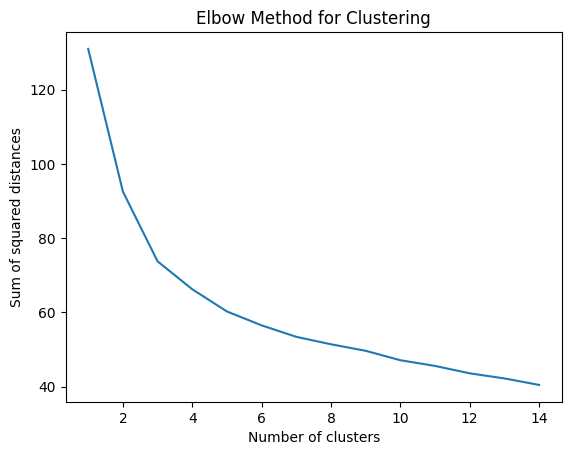

In [89]:
# Nomalized features of the original dataframe
scaled_x_new= MinMaxScaler().fit_transform(x_new)

# Fit the KMeans model to the data with a range of different numbers of clusters
clustering.elbow_method(scaled_x_new)

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

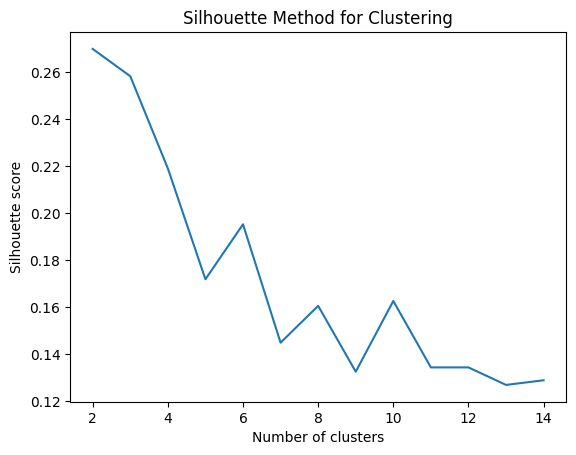

In [49]:
clustering.silhouette_method(scaled_x_new)

In [90]:
# Initialize the KMeans model with 3 clusters
kmeans_new = KMeans(n_clusters=3, random_state=1)

# Fit the model to the data
clusters = kmeans_new.fit_predict(scaled_x_new)  
# Calculate the silhouette score for the generated clusters
silhouette_score(scaled_x_new, clusters)

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.2521595160072952

#### Plot of the second k-means clusters analysis 

/home/asado/Descargas/rockingData/rocking_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/asado/Descargas/rockingData/src/clustering.py:84: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=df2, x='x', y='y', hue='labels', palette=palette)


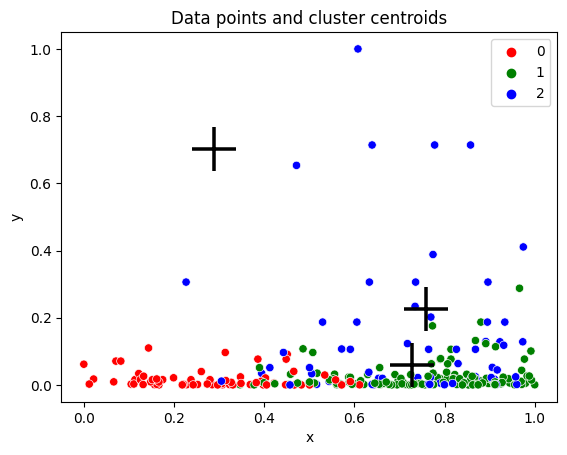

In [91]:
clustering.plot_clusters_with_centroids(scaled_x_new, kmeans_new)

/tmp/ipykernel_12054/3104957421.py:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=df2, x='x', y='y', hue=labels, palette=palette)


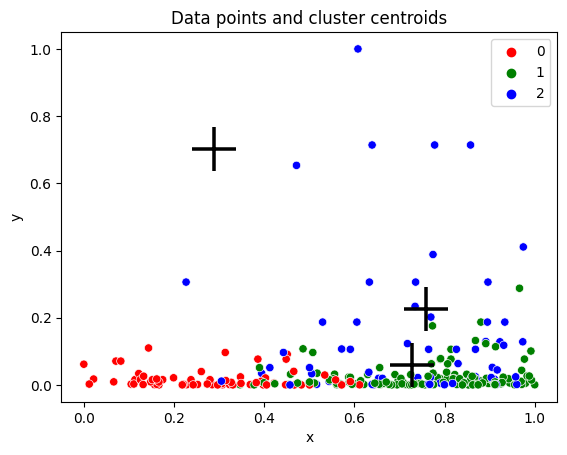

In [92]:
labels = kmeans_new.labels_
centroids = kmeans_new.cluster_centers_
palette = ["red", "green", "blue", "purple"]
# Preparing a dataframe with the numpy array of the scaled vectors and plot of the labels and centroids
df2 = pd.DataFrame({'x': scaled_x_new[:, 0], 'y': scaled_x_new[:, -1]})
sns.scatterplot(data=df2, x='x', y='y', hue=labels, palette=palette)

# Centroids
centros_df = pd.DataFrame({'x': centroids[:, 0], 'y': centroids[:, 1]})
sns.scatterplot(data=centros_df, x='x', y='y', color='black', marker="+", s=1000)

plt.title('Data points and cluster centroids')
plt.show()

#### Features importance on each cluster for the second k-means analysis

/tmp/ipykernel_12054/1209145172.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = clustered_df.groupby('cluster').mean()


         danceability    energy       key  loudness      mode  speechiness  \
cluster                                                                      
0           -0.561150 -1.302726  0.127375 -0.965241  0.246307    -0.198484   
1            0.463414  0.496521 -0.037682  0.390408 -0.128919     0.132908   
2           -0.344075  0.378829 -0.059127  0.234918 -0.000393    -0.058675   

         acousticness  instrumentalness  liveness   valence     tempo  \
cluster                                                                 
0            1.259735          0.416839 -0.202072 -0.776137 -0.492551   
1           -0.266403         -0.138822  0.083423  0.807701  0.194746   
2           -0.800801         -0.161978  0.045742 -0.814853  0.128973   

         duration_ms  song_popularity  artist_popularity  artist_followers  \
cluster                                                                      
0          -0.086553        -0.393107          -0.466458         -0.284940   
1        

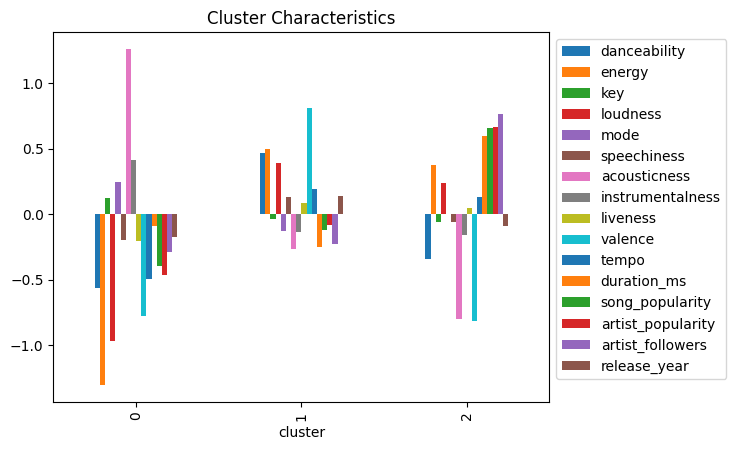

In [224]:
# Normalize the values of each column
x_norm = (x - x.mean()) / x.std()
# Dataframe with the cluster assignments as a column
clustered_df = x_norm.copy()
clustered_df['cluster'] = clusters
clustered_df["artist_genres"] = df["artist_genres"]
clustered_df["artist"] = df["artist"]
# Group the data by cluster and compute the mean of each column to examine the characteristics of the individual clusters
cluster_means = clustered_df.groupby('cluster').mean()
print(cluster_means)

#Compare the clusters to each other by creating a plot of the cluster means
cluster_means.plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [228]:
# Filter the DataFrame for cluster 0
cluster_0 = clustered_df[clustered_df["cluster"] == 0]

# Get the value_counts of "artist_genres" and "artist"
artist_genres_counts = cluster_0["artist_genres"].value_counts().head(10)
artist_counts = cluster_0["artist"].value_counts().head(10)


artist_counts, artist_genres_counts

(Édith Piaf                             4
 Rubén Patagonia                        2
 Juan D'Arienzo                         2
 Los Tucu Tucu                          2
 Simon & Garfunkel                      2
 Les Misérables-Original London Cast    2
 Giuseppe Verdi                         2
 Billy Joel                             2
 Alannah Myles                          1
 Johann Sebastian Bach                  1
 Name: artist, dtype: int64,
 ['chanson', ' torch song', ' vintage schlager']                                                 4
 ['folklore argentino']                                                                          2
 ['broadway', ' hollywood', ' show tunes']                                                       2
 ['classic rock', ' mellow gold', ' piano rock', ' rock', ' singer-songwriter', ' soft rock']    2
 ['classical', ' italian opera', ' italian romanticism', ' late romantic era']                   2
 ['chanson']                                            

In [ ]:
# Filter the DataFrame for cluster 1
cluster_1 = clustered_df[clustered_df["cluster"] == 1]

# Get the value_counts of "artist_genres" and "artist"
artist_genres_counts = cluster_1["artist_genres"].value_counts().head(10)
artist_counts = cluster_1["artist"].value_counts().head(10)


artist_counts, artist_genres_counts

In [ ]:
# Filter the DataFrame for cluster 2
cluster_2 = clustered_df[clustered_df["cluster"] == 2]

# Get the value_counts of "artist_genres" and "artist"
artist_genres_counts = cluster_2["artist_genres"].value_counts().head(10)
artist_counts = cluster_2["artist"].value_counts().head(10)


artist_counts, artist_genres_counts

### DBScan

In [201]:
db = DBSCAN(eps=0.4, min_samples=11)
db.fit(scaled_x_new)
labels = db.labels_ #Obtain labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0) #Obtain number of clusters

In [183]:
density.plot_DBSCAN(scaled_x,labels,db,n_clusters)

NameError: name 'density' is not defined

In [203]:
pca = decomposition.PCA(n_components=2)
pca.fit(x_new)
df2 = pca.transform(x_new)

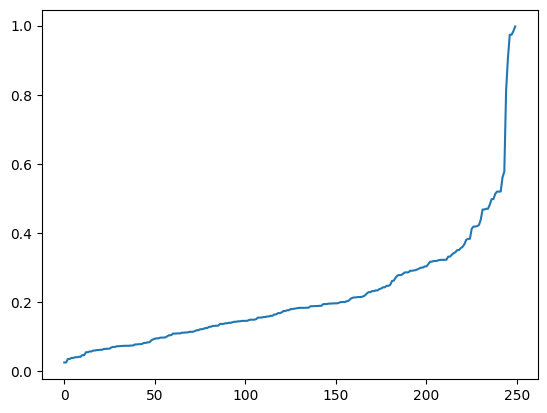

In [205]:

neighbors = 11
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(df2)
distances, indices = nbrs.kneighbors(df2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [231]:
# Fit the model to the data and make clusters predictions
clusters_dbs = db.fit_predict(scaled_x_new)  

/tmp/ipykernel_12054/975202516.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = clustered_df.groupby('cluster').mean()


         danceability    energy       key  loudness      mode  speechiness  \
cluster                                                                      
0           -0.561150 -1.302726  0.127375 -0.965241  0.246307    -0.198484   
1            0.463414  0.496521 -0.037682  0.390408 -0.128919     0.132908   
2           -0.344075  0.378829 -0.059127  0.234918 -0.000393    -0.058675   

         acousticness  instrumentalness  liveness   valence     tempo  \
cluster                                                                 
0            1.259735          0.416839 -0.202072 -0.776137 -0.492551   
1           -0.266403         -0.138822  0.083423  0.807701  0.194746   
2           -0.800801         -0.161978  0.045742 -0.814853  0.128973   

         duration_ms  song_popularity  artist_popularity  artist_followers  \
cluster                                                                      
0          -0.086553        -0.393107          -0.466458         -0.284940   
1        

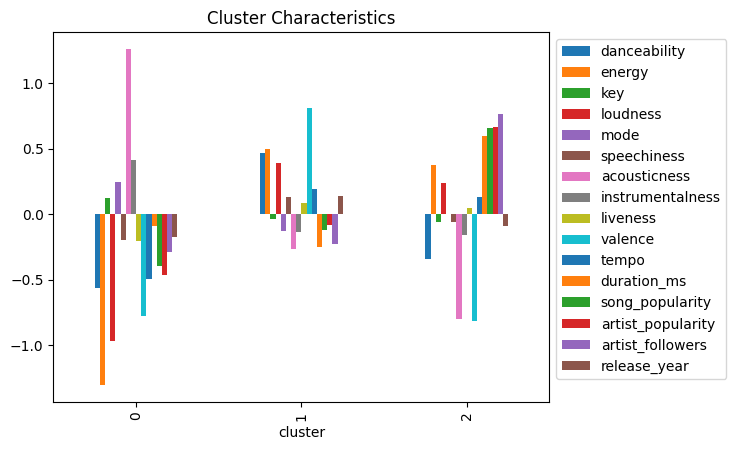

In [232]:
# Normalize the values of each column
x_norm = (x_new - x_new.mean()) / x_new.std()
# Dataframe with the cluster assignments as a column
clustered_df_dbs = x_norm.copy()
clustered_df_dbs['cluster'] = clusters_dbs
clustered_df_dbs["artist_genres"] = df["artist_genres"]
clustered_df_dbs["artist"] = df["artist"]
# Group the data by cluster and compute the mean of each column to examine the characteristics of the individual clusters
cluster_means = clustered_df.groupby('cluster').mean()
print(cluster_means)

#Compare the clusters to each other by creating a plot of the cluster means
cluster_means.plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
# Filter the DataFrame for cluster 0
cluster_0 = clustered_df[clustered_df["cluster"] == 0]

# Get the value_counts of "artist_genres" and "artist"
artist_genres_counts = cluster_0["artist_genres"].value_counts().head(10)
artist_counts = cluster_0["artist"].value_counts().head(10)


artist_counts, artist_genres_counts

In [ ]:
# Filter the DataFrame for cluster 1
cluster_1 = clustered_df[clustered_df["cluster"] == 1]

# Get the value_counts of "artist_genres" and "artist"
artist_genres_counts = cluster_1["artist_genres"].value_counts().head(10)
artist_counts = cluster_1["artist"].value_counts().head(10)


artist_counts, artist_genres_counts